# Tests
This notebook is used to test some of the functions created in main.py and verify if they work as expected

## Test batch creation

In [1]:
from main import *
from helpers import *
from ds import *

c:\Users\jputz\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found cached dataset parquet (C:/Users/jputz/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-1680095ec7b2b03f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 140.74it/s]
Loading cached shuffled indices for dataset at C:\Users\jputz\.cache\huggingface\datasets\segments___parquet\segments--sidewalk-semantic-2-1680095ec7b2b03f\0.0.0\14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7\cache-5eeb6ee8ca16ffb9.arrow


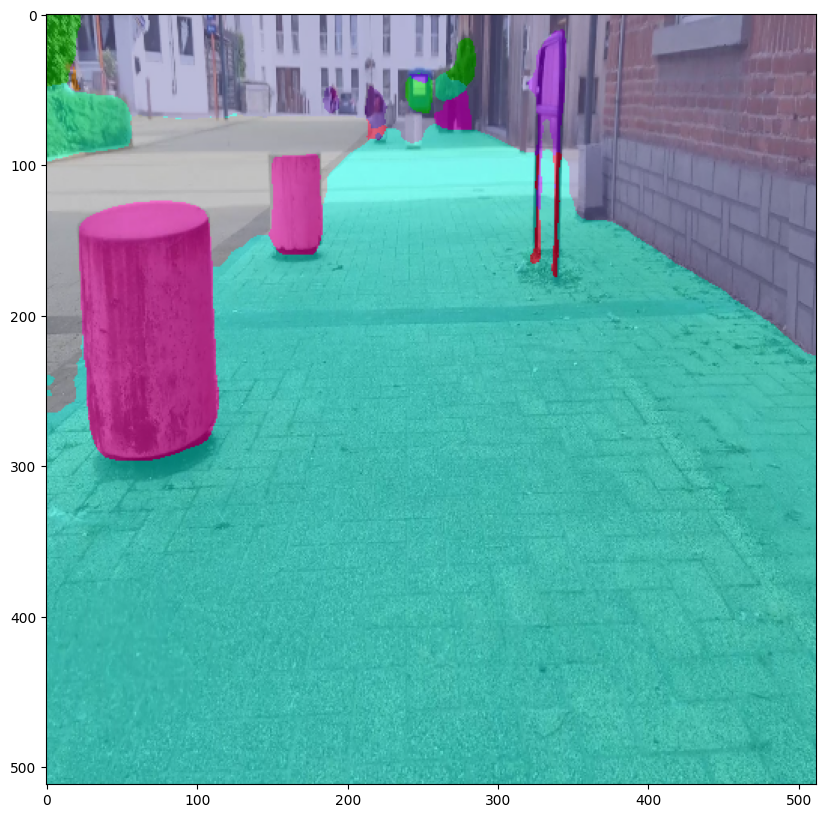

In [2]:
processor, model = load_model("facebook/mask2former-swin-tiny-ade-semantic")
train_ds, test_ds = make_dataset("segments/sidewalk-semantic")
image, map, _, _ = test_ds[0]
pred = infer_img(processor, model, image)
show_overlay(image, pred)

In [3]:
train_dataloader, test_dataloader = create_batch(train_ds, test_ds, 2, processor)

In [4]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 384, 384])
pixel_mask torch.Size([2, 384, 384])
mask_labels torch.Size([8, 384, 384])
class_labels torch.Size([8])
original_images (1080, 1920, 3)
original_segmentation_maps (1080, 1920)


In [5]:
pixel_values = batch["pixel_values"][0].numpy()

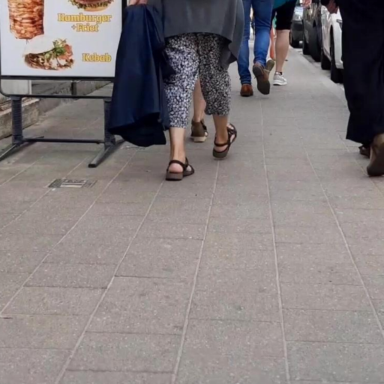

In [6]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [7]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['flat-sidewalk', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'vehicle-car', 'construction-building', 'void-static', 'void-unclear']


In [8]:
# verify mask labels
batch["mask_labels"][0].shape

torch.Size([8, 384, 384])

In [9]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: flat-sidewalk


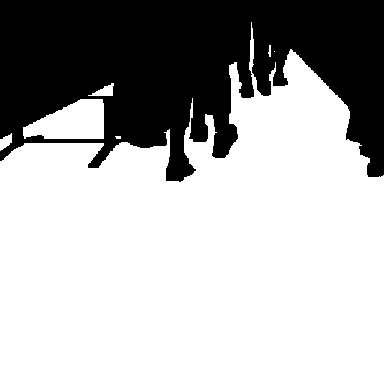

In [10]:
visualize_mask(labels, "flat-sidewalk")

----
## Test Training

In [11]:
batch = next(iter(train_dataloader))
outputs = print_initial_loss(model, batch)

Initial loss: tensor([135.7313], grad_fn=<AddBackward0>)


In [12]:
if torch.cuda.is_available():
        print("using cuda!")
        device = "cuda:0"
else:
    print("using cpu.")
    device = "cpu"

using cpu.


In [14]:
model = train_model(model, train_dataloader, device, epochs = 1)

Epoch: 0


  0%|          | 0/400 [00:00<?, ?it/s]


Loss: 70.58216094970703


  1%|▏         | 5/400 [01:10<1:32:29, 14.05s/it]


KeyboardInterrupt: 

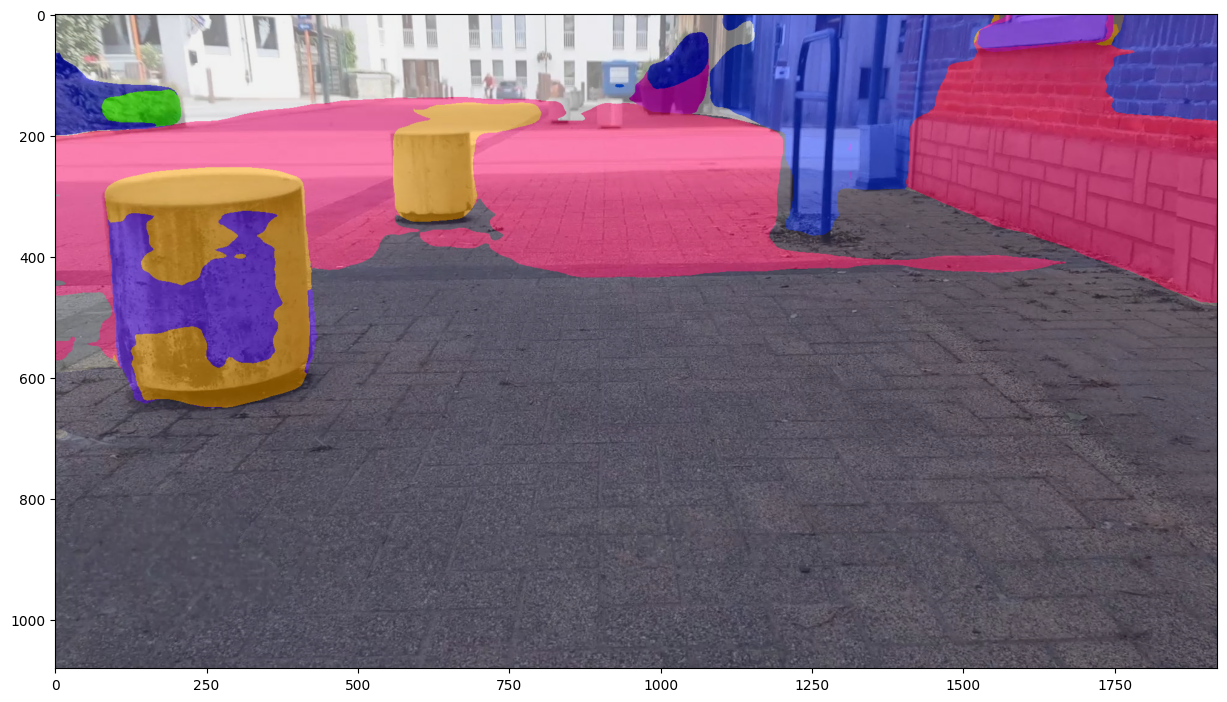

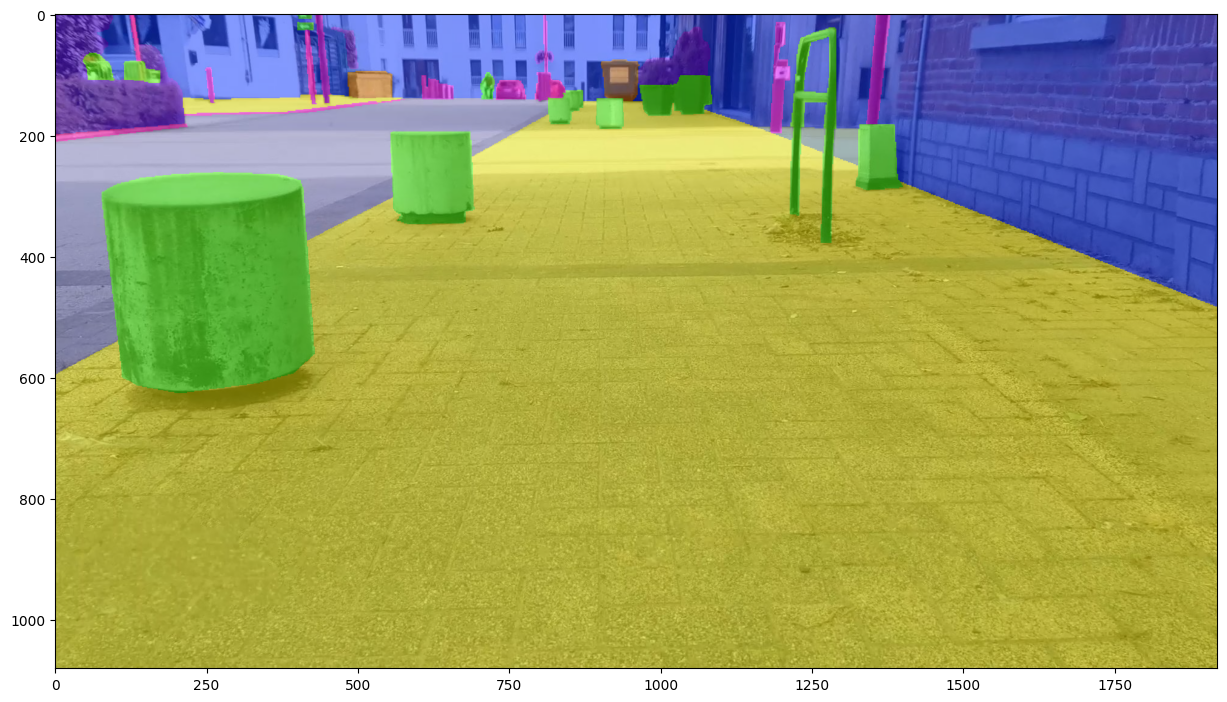

In [15]:
inference(model, test_dataloader, processor)